In [2]:
import sys
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sqlalchemy import create_engine, inspect

In [3]:
def scrape_news(url, site_name):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        print(f"Отримання даних з {site_name}...")
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, 'html.parser')
        news_items = []
        
        # Універсальний пошук новинних заголовків і посилань
        news_elements = soup.select('a[href*="article"], a[href*="news"], a[href*="/202"]')
        
        for element in news_elements[:20]:  # Обмежуємо кількість
            title = element.get_text(strip=True)
            link = element['href']
            
            if title and len(title) > 10:  # Фільтруємо короткі/порожні заголовки
                if not link.startswith('http'):
                    link = requests.compat.urljoin(url, link)
                
                news_items.append({
                    'title': title,
                    'link': link,
                    'source': site_name
                })
        
        if not news_items:
            raise ValueError("Не знайдено новин за універсальними селекторами")
        
        return news_items
    
    except Exception as e:
        print(f"Помилка при парсингу {site_name}: {e}")
        return None

# Список сайтів для парсингу
sites = [
    {'url': 'https://www.unian.ua/',         'name': 'UNIAN'},
    {'url': 'https://www.ukrinform.ua/',     'name': 'Ukrinform'},
    {'url': 'https://www.pravda.com.ua/',    'name': 'Українська правда'},
]

all_news = []
for site in sites:
    news = scrape_news(site['url'], site['name'])
    if news:
        all_news.extend(news)

if all_news:
    df = pd.DataFrame(all_news)
    df.to_csv('news_raw.csv', index=False)
    print(f"\nУспішно зібрано {len(all_news)} новин!")
    display(df.head())
else:
    print("Не вдалося отримати новини з жодного сайту")

Отримання даних з UNIAN...
Отримання даних з Ukrinform...
Отримання даних з Українська правда...

Успішно зібрано 32 новин!


,title,link,source
0,Травень в Україні почнеться з дощів та гроз: с...,https://www.unian.ua/pogoda/news/traven-v-ukra...,UNIAN
1,США ВІДШИЛИ Путіна. Новий НАСТУП РФ та терміно...,https://www.unian.ua/multimedia/video/news/105...,UNIAN
2,❗️3 ХВИЛИНИ ТОМУ: Захват ОДЕСИ із застосування...,https://www.unian.ua/multimedia/video/news/105...,UNIAN
3,🔥Парад в Москві скасовується! Зеленський смієт...,https://www.unian.ua/multimedia/video/news/105...,UNIAN
4,4 ХВИЛИНИ ТОМУ: Путин допік Трампа! Це не пере...,https://www.unian.ua/multimedia/video/news/105...,UNIAN


In [4]:
# Завантаження сирих даних
try:
    df = pd.read_csv('news_raw.csv')
    print("Дані успішно завантажені. Перші 10 записів:")
    display(df.head(10))
    
    # Очистка даних
    print("\nПочаток очистки даних...")
    
    # 1. Видалення дублікатів
    initial_count = len(df)
    df.drop_duplicates(subset=['title', 'link'], keep='first', inplace=True)
    print(f"Видалено {initial_count - len(df)} дублікатів")
    
    # 2. Обробка пропусків
    df['title'].fillna('No title', inplace=True)
    df['link'].fillna('', inplace=True)
    
    # 3. Додаткові перетворення
    df['title_length'] = df['title'].apply(len)
    df['clean_title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # Видалення спецсимволів
    df['domain'] = df['link'].apply(lambda x: x.split('/')[2] if x.startswith('http') else '')
    df['scraped_date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    # 4. Категоризація за довжиною заголовка
    df['title_category'] = pd.cut(df['title_length'],
                                bins=[0, 40, 80, 120, 200],
                                labels=['short', 'medium', 'long', 'extra_long'])
    
    # Збереження очищених даних
    df.to_csv('news_cleaned.csv', index=False)
    print("\nОчищені дані збережено у news_cleaned.csv")
    print("Приклад оброблених даних:")
    display(df[['title', 'source', 'domain', 'title_category']].head(10))
    
except Exception as e:
    print(f"Помилка при трансформації даних: {e}")

Дані успішно завантажені. Перші 10 записів:


,title,link,source
0,Травень в Україні почнеться з дощів та гроз: с...,https://www.unian.ua/pogoda/news/traven-v-ukra...,UNIAN
1,США ВІДШИЛИ Путіна. Новий НАСТУП РФ та терміно...,https://www.unian.ua/multimedia/video/news/105...,UNIAN
2,❗️3 ХВИЛИНИ ТОМУ: Захват ОДЕСИ із застосування...,https://www.unian.ua/multimedia/video/news/105...,UNIAN
3,🔥Парад в Москві скасовується! Зеленський смієт...,https://www.unian.ua/multimedia/video/news/105...,UNIAN
4,4 ХВИЛИНИ ТОМУ: Путин допік Трампа! Це не пере...,https://www.unian.ua/multimedia/video/news/105...,UNIAN
5,"Сазонов НЕ СТРИМАВ ЕМОЦІЙ! Як виграти війну, к...",https://www.unian.ua/multimedia/video/news/105...,UNIAN
6,"Довго сплячий ""зомбі""-вулкан Болівії повертаєт...",https://www.unian.ua/pogoda/news/zombi-vulkan-...,UNIAN
7,"Довго сплячий ""зомбі""-вулкан Болівії повертаєт...",https://www.unian.ua/pogoda/news/zombi-vulkan-...,UNIAN
8,Над Вінницею з’явилося незвичайне світлове яви...,https://www.unian.ua/pogoda/news/pogoda-vinnic...,UNIAN
9,Травень в Україні почнеться з дощів та гроз: с...,https://www.unian.ua/pogoda/news/traven-v-ukra...,UNIAN



Початок очистки даних...
Видалено 5 дублікатів
Помилка при трансформації даних: name 'datetime' is not defined


C:\Users\unggo\AppData\Local\Temp\ipykernel_35580\1503528065.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['title'].fillna('No title', inplace=True)
C:\Users\unggo\AppData\Local\Temp\ipykernel_35580\1503528065.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [5]:
try:
    # Завантаження оброблених даних
    df = pd.read_csv('news_cleaned.csv')

    # Підключення до SQLite через SQLAlchemy
    engine = create_engine('sqlite:///news_database.db')

    # Створення інспектора
    inspector = inspect(engine)

    # Створення таблиці (якщо не існує)
    if not inspector.has_table('news_articles'):
        df.to_sql('news_articles', engine, index=False)
        print("Таблицю 'news_articles' створено та дані завантажено.")
    else:
        # Додавання нових даних (без дублікатів)
        existing_links = pd.read_sql('SELECT link FROM news_articles', engine)['link'].tolist()
        new_data = df[~df['link'].isin(existing_links)]

        if not new_data.empty:
            new_data.to_sql('news_articles', engine, if_exists='append', index=False)
            print(f"Додано {len(new_data)} нових записів.")
        else:
            print("Нових даних для додавання не знайдено.")

    # Перевірка даних у базі
    conn = sqlite3.connect('news_database.db')
    db_sample = pd.read_sql('SELECT * FROM news_articles LIMIT 5', conn)
    conn.close()

    print("\nПерші 5 записів з бази даних:")
    print(db_sample)

except Exception as e:
    print(f"Помилка при завантаженні даних: {e}")

Нових даних для додавання не знайдено.
Помилка при завантаженні даних: name 'sqlite3' is not defined


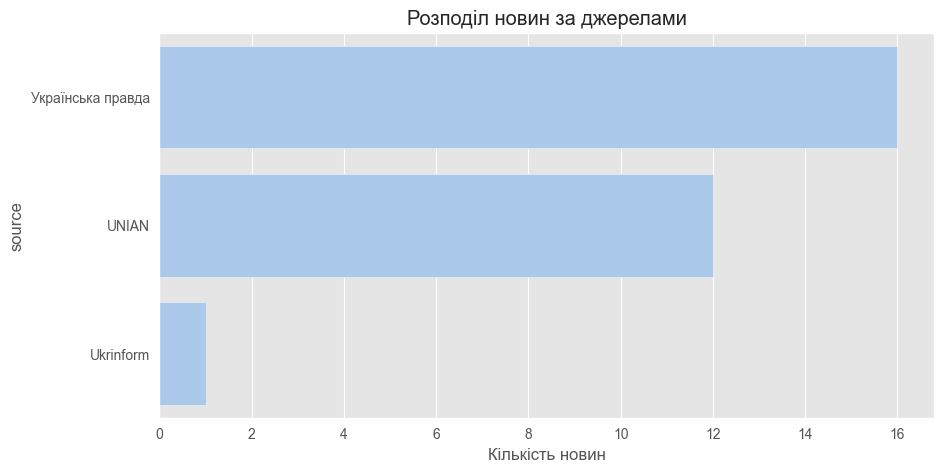

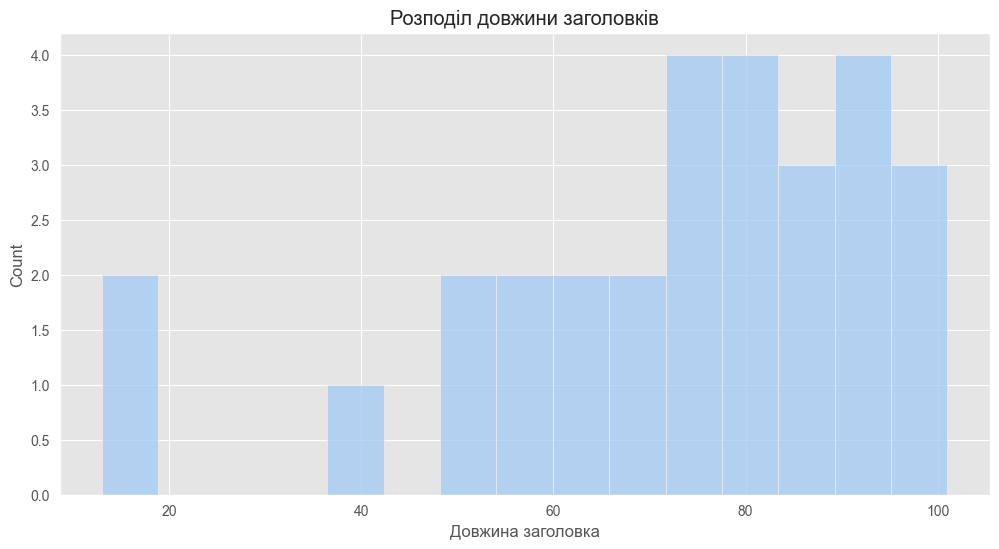

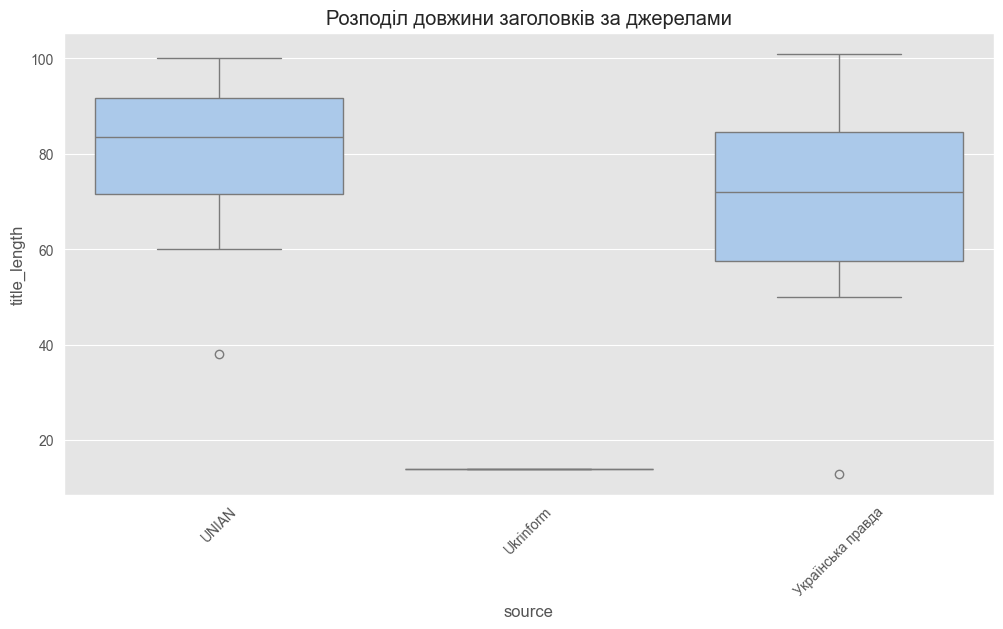

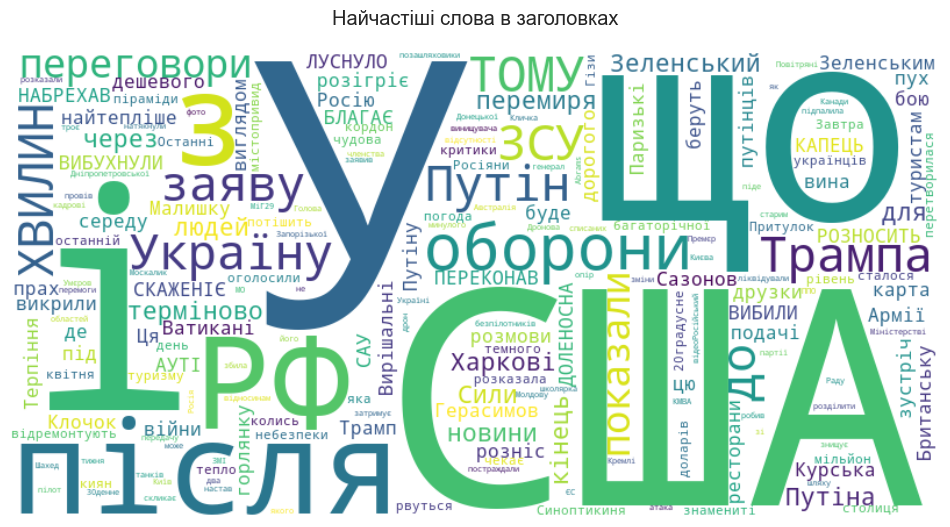


Статистика довжини заголовків:
count     29.000000
mean      71.896552
std       22.960128
min       13.000000
25%       60.000000
50%       77.000000
75%       89.000000
max      101.000000
Name: title_length, dtype: float64


In [7]:
# Налаштування стилю
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("pastel")

try:
    # Завантаження даних
    df = pd.read_csv('news_cleaned.csv')
    
    # Перевірка наявності необхідних стовпців
    if 'title' not in df.columns:
        raise KeyError("Стовпець 'title' відсутній у даних")
    
    # Додаємо необхідні обчислені стовпці, якщо вони відсутні
    if 'title_length' not in df.columns:
        df['title_length'] = df['title'].apply(len)
    
    if 'clean_title' not in df.columns:
        df['clean_title'] = df['title'].str.replace(r'[^\w\s]', '', regex=True)
    
    if 'source' not in df.columns:
        df['source'] = 'Unknown'
    
    # 1. Аналіз розподілу новин за джерелами
    plt.figure(figsize=(10, 5))
    source_counts = df['source'].value_counts()
    sns.barplot(x=source_counts.values, y=source_counts.index)
    plt.title('Розподіл новин за джерелами')
    plt.xlabel('Кількість новин')
    plt.show()
    
    # 2. Аналіз довжини заголовків
    plt.figure(figsize=(12, 6))
    sns.histplot(df['title_length'], bins=15, kde=False)
    plt.title('Розподіл довжини заголовків')
    plt.xlabel('Довжина заголовка')
    plt.show()
    
    # 3. Порівняння довжини заголовків за джерелами
    if len(df['source'].unique()) > 1:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='source', y='title_length')
        plt.title('Розподіл довжини заголовків за джерелами')
        plt.xticks(rotation=45)
        plt.show()
    
    # 4. Хмара слів з заголовків
    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         stopwords=['в', 'на', 'є', 'туристи', 'туризм', 'за', 'про']).generate(' '.join(df['clean_title']))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Найчастіші слова в заголовках', pad=20)
    plt.show()
    
    # 5. Статистика даних
    print("\nСтатистика довжини заголовків:")
    print(df['title_length'].describe())
    
    # Зберігаємо оновлені дані з новими стовпцями
    df.to_csv('news_cleaned.csv', index=False)
    
except KeyError as e:
    print(f"Помилка: відсутній ключовий стовпець - {e}")
    print("Доступні стовпці:", df.columns.tolist())
except Exception as e:
    print(f"Неочікувана помилка при аналізі даних: {e}")